In [51]:
from itertools import combinations
import numpy as np
import pickle
import os
import sys
import time
import itertools as it

import matplotlib.pyplot as plt
from SALib.sample import saltelli

import tqdm
import contextlib

# sys.path.append('./GDMaps_PCE/')
from DimensionReduction import Grassmann
from DimensionReduction import DiffusionMaps
from GDMaps_PCE_GSA import *

from UQpy.distributions import Normal, Uniform, JointIndependent

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [34]:
def plot_dm_parsim_coord(coord, g):
    
    comb1 = list(combinations(list(coord), 2))
    comb2 = list(combinations([i for i in range(coord.shape[0])], 2))

    # Plot first three plots
    if coord.shape[0] > 2:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
        
        for i in range(len(comb1)):
            ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                          cmap='viridis', s=30, edgecolors='k', linewidth=0.2)
            ax[i].set_xlabel(r'$\theta_{{{}}}$'.format(comb1[i][0]))
            ax[i].set_ylabel(r'$\theta_{{{}}}$'.format(comb1[i][1]))
            ax[i].grid('True')
            ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        plt.show()
        
        
def plot_dm_parsim_coord_multi_level(coords, gs):
    
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    
    titles = ["Micro-Level Diffusion Coordinates",
              #"Meso-Level Diffusion Coordinates",
              "Global-Level Diffusion Coordinates"]
    
    for k, coord in enumerate(coords):
        comb1 = list(combinations(list(coord), 2))
        comb2 = list(combinations([i for i in range(coord.shape[0])], 2))
        
        g = gs[k]

        for i in range(len(comb1)):
            axs[k][i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                          cmap='viridis', s=30, edgecolors='k', linewidth=0.2)
            axs[k][i].set_xlabel(r'$\theta_{{{}}}$'.format(comb1[i][0]))
            axs[k][i].set_ylabel(r'$\theta_{{{}}}$'.format(comb1[i][1]))
            axs[k][i].grid('True')
            axs[k][i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))  
        
        axs[k][1].set_title(titles[k], fontsize=20, y=1.2)
    
    fig.tight_layout()
    plt.savefig("diffusion_coordinates.pdf", bbox_inches="tight")
    plt.show()


def run_GDMaps(p, 
               data, 
               num_runs=10, 
               n_keep=3, 
               parsim=True):
    
    evals_diff_runs  = []
    evecs_diff_runs  = []
    coord_diff_runs = []
    g_diff_runs = []
    residuals_diff_runs = []
    index_diff_runs = []
    
    for i in range(num_runs):
        print('Run: ', i)
        data_all = data[i]

        # Perform GDMAps
        start_time = time.time()
        
        if parsim:
            g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data_all, 
                                                                     n_evecs=20,
                                                                     n_keep=n_keep,
                                                                     parsim=parsim,
                                                                     p=p).get()
        
            evals_diff_runs.append(evals)
            evecs_diff_runs.append(evecs)
            coord_diff_runs.append(coord)
            g_diff_runs.append(g)
            residuals_diff_runs.append(residuals)
            index_diff_runs.append(index)
            
        else:
            g, coord, Grass, evals, evecs = GDMaps(data=data_all, 
                                                   n_evecs=20,
                                                   n_keep=n_keep,
                                                   parsim=parsim,
                                                   p=p).get()

            evals_diff_runs.append(evals)
            evecs_diff_runs.append(evecs)
            coord_diff_runs.append(coord)
            g_diff_runs.append(g)
        
        print("--- GDMaps - %s seconds ---" % (time.time() - start_time))
    
    return (evals_diff_runs, evecs_diff_runs, coord_diff_runs, g_diff_runs,
            residuals_diff_runs, index_diff_runs)

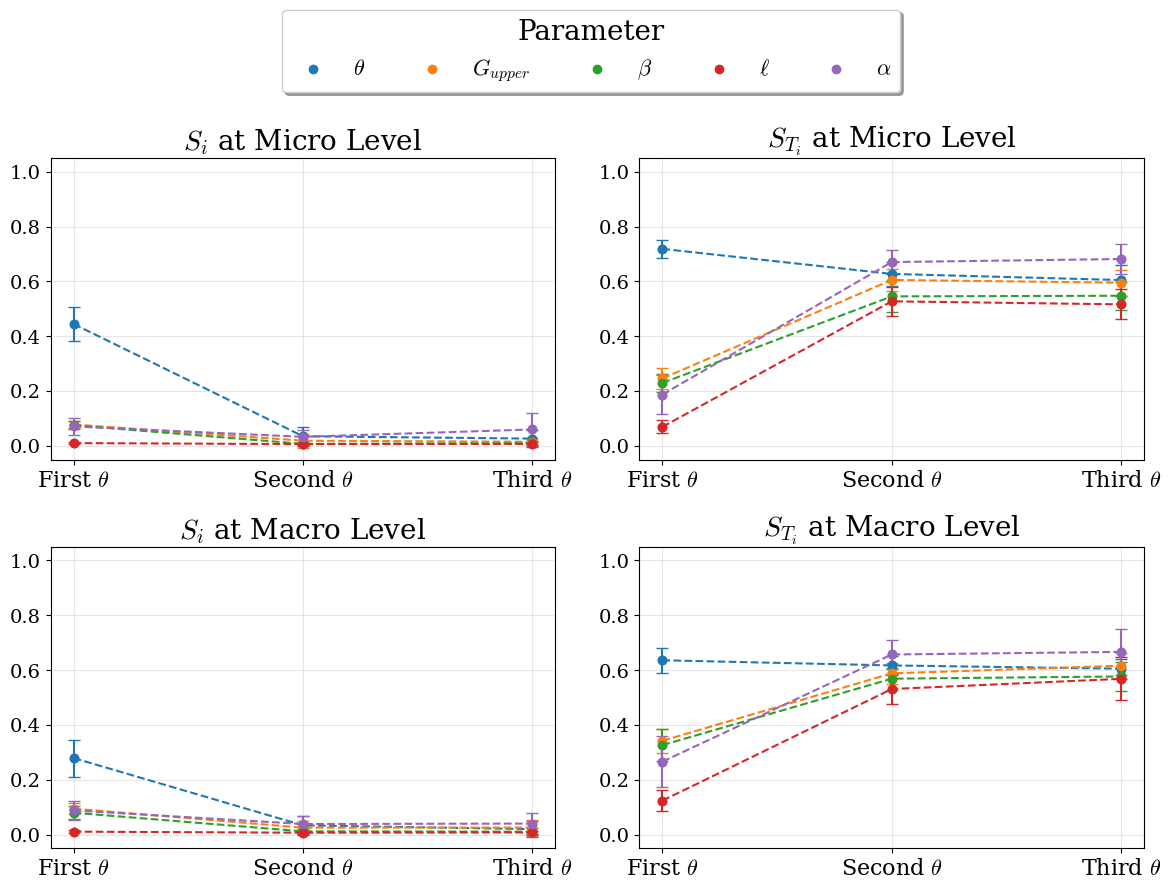

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
param_names = [r"$\theta$", r"$G_{upper}$", r"$\beta$", r"$\ell$", r"$\alpha$"]
theta_labels = [r"First $\theta$", r"Second $\theta$", r"Third $\theta$"]


# MICRO
with open("PCE_LAR_RESULTS_micro.pickle", 'rb') as f:
    [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO] = pickle.load(f)
# First order si
for i, param in enumerate(param_names):
    axs[0][0].scatter([1,2,3],LAR_fo_si.mean(axis=0)[0][i], label=param_names[i])    
    axs[0][0].errorbar([1,2,3], LAR_fo_si.mean(axis=0)[0][i],
                      LAR_fo_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[0][0].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[0][0].set_title(r"$S_i$ at Micro Level", fontsize=20)
    axs[0][0].set_ylim(-0.05,1.05)
# Total order si
for i, param in enumerate(param_names):
    axs[0][1].scatter([1,2,3],LAR_to_si.mean(axis=0)[0][i], label=param_names[i])    
    axs[0][1].errorbar([1,2,3], LAR_to_si.mean(axis=0)[0][i],
                      LAR_to_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[0][1].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[0][1].set_title(r"$S_{T_i}$ at Micro Level", fontsize=20)
    axs[0][1].set_ylim(-0.05,1.05)
    
# MACRO
with open("PCE_LAR_RESULTS_macro_15.pickle", 'rb') as f:
    [LAR_fo_si, LAR_to_si, LAR_error, LAR_LOO] = pickle.load(f)
# First order si
for i, param in enumerate(param_names):
    axs[1][0].scatter([1,2,3],LAR_fo_si.mean(axis=0)[0][i], label=param_names[i])    
    axs[1][0].errorbar([1,2,3], LAR_fo_si.mean(axis=0)[0][i],
                      LAR_fo_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[1][0].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[1][0].set_title(r"$S_i$ at Macro Level", fontsize=20)
    axs[1][0].set_ylim(-0.05,1.05)
# Total order si
for i, param in enumerate(param_names):
    axs[1][1].scatter([1,2,3],LAR_to_si.mean(axis=0)[0][i], label=param_names[i])    
    axs[1][1].errorbar([1,2,3], LAR_to_si.mean(axis=0)[0][i],
                      LAR_to_si.std(axis=0, ddof=1)[0][i],
                      linestyle='--', marker='o', capsize=4)
    axs[1][1].set_xticks([1,2,3], labels=theta_labels, fontsize=16)
    axs[1][1].set_title(r"$S_{T_i}$ at Macro Level", fontsize=20)
    axs[1][1].set_ylim(-0.05,1.05)

    
handles, labels = axs[1][1].get_legend_handles_labels()
legend = fig.legend(handles, labels, title="Parameter", ncol=6, 
                    bbox_to_anchor=(0.77,1.13), fontsize=16, shadow=True)
legend.get_title().set_fontsize('20') #legend 'Title' fontsize


fig.tight_layout()
plt.savefig("sensitivity_indices_paper.pdf", bbox_inches="tight")
plt.show()

# Diffusion Coordinates

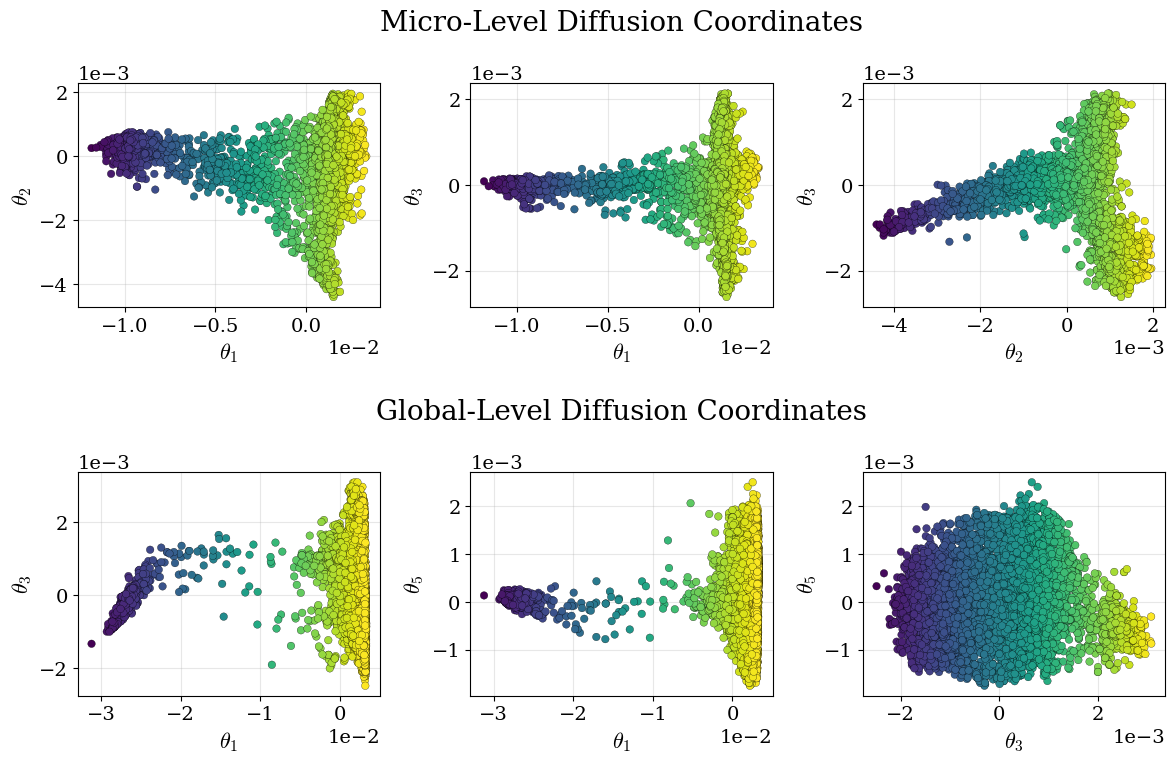

In [58]:
coords = []
gs = []

seed = 13

for i,path in enumerate([f"../micro_gsa/micro_{seed}.pickle"]):
    with open("../micro_gsa/" + path, "rb") as f:
        evals, evecs_diff_runs, coord, g_diff_runs, \
            residuals_diff_runs, index_diff_runs = pickle.load(f)
    coords.append(coord[0])
    gs.append(g_diff_runs[0])

for i,path in enumerate([f"../GDMaps_results_nodebt/macro_{seed}.pickle"]):
    with open("../GDMaps_results_nodebt/" + path, "rb") as f:
        evals, evecs_diff_runs, coord, g_diff_runs, \
            residuals_diff_runs, index_diff_runs = pickle.load(f)
    coords.append(coord[0])
    gs.append(g_diff_runs[0])
    
plot_dm_parsim_coord_multi_level(coords, gs)